In [47]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve, plot_confusion_matrix, confusion_matrix

from sklearn.inspection import permutation_importance

from datetime import datetime as dt
import time

import seaborn as sns

In [2]:
#importing the files from the previous notebook 

with open('./datasetsZ_train.pickle','rb') as read_file:
    Z_train = pickle.load(read_file)

with open('./datasets/y_train.pickle','rb') as read_file:
    y_train = pickle.load(read_file)

with open('./datasets/Z_test.pickle','rb') as read_file:
    Z_test = pickle.load(read_file)

with open('./datasets/y_test.pickle','rb') as read_file:
    y_test = pickle.load(read_file)

In [3]:
print(Z_train.shape)
print(y_train.shape)

(15822, 232)
(15822,)


In [4]:
print(Z_test.shape)
print(y_test.shape)

(2089, 232)
(2089,)


In [5]:
def get_metrics(modelname, model, Z_train, y_train):
    print(modelname)
    print(u'\u2500' * 30)
    print(f"Accuracy score of training set: {round(100* model.score(Z_train, y_train),2)}%")
    print(f"Accuracy score of testing set: {round(100* model.score(Z_test, y_test),2)}%")
    print(u'\u2500' * 30)    
    return plot_confusion_matrix(model, Z_test, y_test)

### GradientBoost

In [6]:
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3],
    "max_depth":[3, 5, 8, 10, 12],
    "n_estimators":[10, 100, 150, 200, 250, 300, 350, 400],
    "max_features":["log2","sqrt"]
    }

#passing the scoring function in the GridSearchCV
GBM = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters, scoring='roc_auc',cv=5, n_jobs=-1)

In [7]:
GBM.fit(Z_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15,
                                           0.2, 0.25, 0.3],
                         'max_depth': [3, 5, 8, 10, 12],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [10, 100, 150, 200, 250, 300, 350,
                                          400]},
             scoring='roc_auc')

In [8]:
print(f'Best parameters are: {GBM.best_params_}')

Best parameters are: {'learning_rate': 0.15, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 400}


Gradient Boost Classifier
──────────────────────────────
Accuracy score of training set: 99.9%
Accuracy score of testing set: 82.56%
──────────────────────────────


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


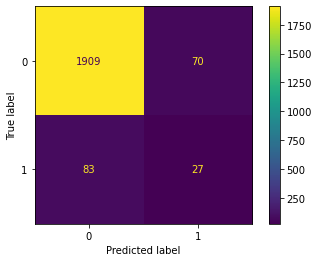

In [9]:
#print accuracy score for train and test set
get_metrics('Gradient Boost Classifier', GBM, Z_train, y_train)

In [10]:
#get predictions
preds = GBM.predict(Z_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate accuracy, misclassification, specificity, sensitivity and precision
accuracy = (tp + tn) / (tp + tn + fp + fn)
misclassification = 1 - accuracy
spec = tn / (tn + fp)
sen = tp/(tp + fn)
precision = tp / (tp + fp)

print('Accuracy:', accuracy)
print('Misclassification:', misclassification)
print('Sensitivity:', sen)
print('Specificity:', spec)
print('Precision:', precision)
print('')
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

Accuracy: 0.9267592149353758
Misclassification: 0.07324078506462417
Sensitivity: 0.24545454545454545
Specificity: 0.9646286003031834
Precision: 0.27835051546391754

True Negatives: 1909
False Positives: 70
False Negatives: 83
True Positives: 27


### RandomForest

In [11]:
# Hyperparameters
rf_params = {'n_estimators': [50, 100, 200, 400, 800, 1600],
             'max_depth': [1, 2, 5, 10],
             'min_samples_split': [10, 20, 30],
             'min_samples_leaf':[5, 10, 15]
}

# instantiate GridSearchCV
grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                      param_grid=rf_params, scoring='roc_auc',
                      cv=5, n_jobs=-1)

In [12]:
grid_rf.fit(Z_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [50, 100, 200, 400, 800, 1600]},
             scoring='roc_auc')

In [13]:
print(f'The best parameters are {grid_rf.best_estimator_}.')

The best parameters are RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=1600, random_state=42).


Random Forest Classifier
──────────────────────────────
Accuracy score of training set: 94.9%
Accuracy score of testing set: 82.93%
──────────────────────────────


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


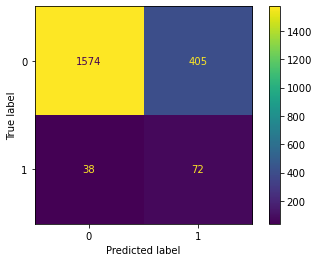

In [14]:
#print accuracy score for train and test set
get_metrics('Random Forest Classifier', grid_rf, Z_train, y_train)

In [15]:
# Get predictions
preds2 = grid_rf.predict(Z_test)

# Save confusion matrix values
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds2).ravel()

# Calculate accuracy, misclassification, specificity, sensitivity and precision
accuracy2 = (tp2 + tn2) / (tp2 + tn2 + fp2 + fn2)
misclassification2 = 1 - accuracy2
spec2 = tn2 / (tn2 + fp2)
sen2 = tp2/(tp2+fn2)
precision2 = tp2 / (tp2 + fp2)

print('Accuracy:', accuracy2)
print('Misclassification:', misclassification2)
print('Sensitivity:', sen2)
print('Specificity:', spec2)
print('Precision:', precision2)
print('')
print("True Negatives:", tn2)
print("False Positives:", fp2)
print("False Negatives:", fn2)
print("True Positives:", tp2)

Accuracy: 0.7879368118717089
Misclassification: 0.21206318812829106
Sensitivity: 0.6545454545454545
Specificity: 0.7953511874684184
Precision: 0.1509433962264151

True Negatives: 1574
False Positives: 405
False Negatives: 38
True Positives: 72


### Logistic Regression

In [16]:
#Hyperparameters
lr_params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}

# instantiate GridSearchCV
grid_lr = GridSearchCV(estimator=LogisticRegression(random_state=42, max_iter=5000),
                       param_grid=lr_params, cv=5, scoring='roc_auc', n_jobs = -1)

In [17]:
grid_lr.fit(Z_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalt

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalt

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')

In [18]:
print(f'The best parameters are {grid_lr.best_estimator_}.')

The best parameters are LogisticRegression(C=1e-05, max_iter=5000, penalty='none', random_state=42).


Logistic Regression Classifier
──────────────────────────────
Accuracy score of training set: 90.8%
Accuracy score of testing set: 78.03%
──────────────────────────────


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


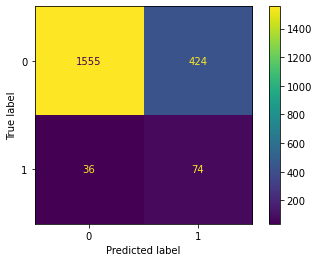

In [19]:
#print accuracy score for train and test set
get_metrics('Logistic Regression Classifier', grid_lr, Z_train, y_train)

In [20]:
# Get predictions
preds3 = grid_lr.predict(Z_test)

# Save confusion matrix values
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, preds3).ravel()

# Calculate accuracy, misclassification, specificity, sensitivity and precision
accuracy3 = (tp3 + tn3) / (tp3 + tn3 + fp3 + fn3)
misclassification3 = 1 - accuracy3
spec3 = tn3 / (tn3 + fp3)
sen3 = tp3/(tp3+fn3)
precision3 = tp3 / (tp3 + fp3)

print('Accuracy:', accuracy3)
print('Misclassification:', misclassification3)
print('Sensitivity:', sen3)
print('Specificity:', spec3)
print('Precision:', precision3)
print('')
print("True Negatives:", tn3)
print("False Positives:", fp3)
print("False Negatives:", fn3)
print("True Positives:", tp3)

Accuracy: 0.7797989468645284
Misclassification: 0.22020105313547156
Sensitivity: 0.6727272727272727
Specificity: 0.7857503789792825
Precision: 0.14859437751004015

True Negatives: 1555
False Positives: 424
False Negatives: 36
True Positives: 74


### AUC ROC Score

In [21]:
#print AUC Socre
p = GBM.predict_proba(Z_test)
p2 = grid_rf.predict_proba(Z_test)
p3 = grid_lr.predict_proba(Z_test)

p = p[:, 1]
p2 = p2[:, 1]
p3 = p3[:, 1]

auc = round(roc_auc_score(y_test, p),2)
auc2 = round(roc_auc_score(y_test, p2),2)
auc3 = round(roc_auc_score(y_test, p3),2)

print('GBM:', auc)
print('RF:', auc2)
print('LR:', auc3)

GBM: 0.83
RF: 0.83
LR: 0.78


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be r

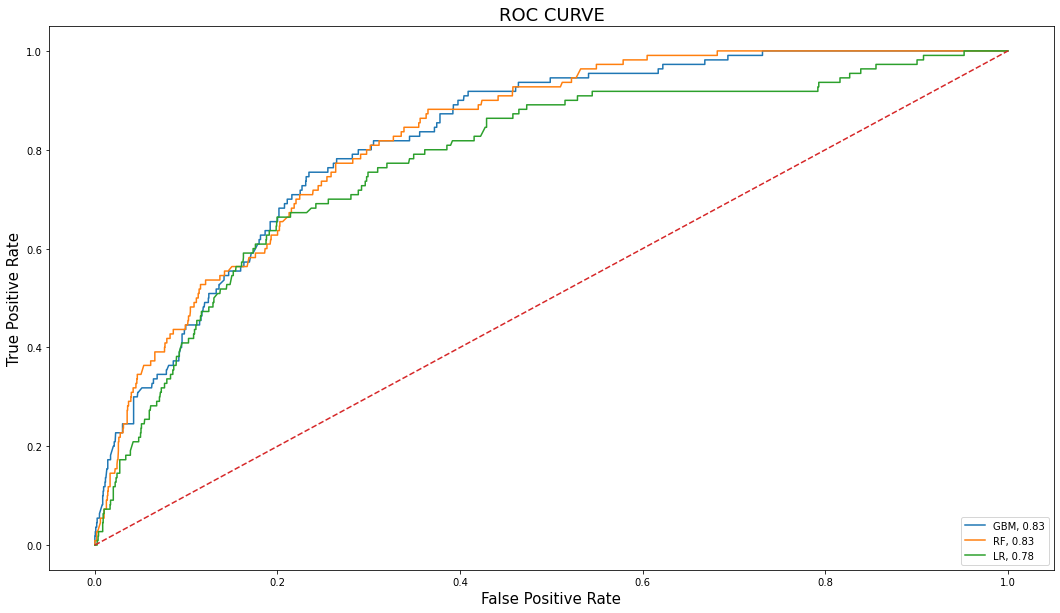

In [22]:
#print ROC Curve
plt.rcParams["figure.figsize"] = (18,10)

GBM_roc = plot_roc_curve(GBM, Z_test, y_test, label=f'GBM, {auc}')
RF_roc = plot_roc_curve(grid_rf, Z_test, y_test, ax = GBM_roc.ax_, label=f'RF, {auc2}')
LR_roc = plot_roc_curve(grid_lr, Z_test, y_test, ax = GBM_roc.ax_, label=f'LR, {auc3}')
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--') 

plt.title("ROC CURVE", fontsize = 18)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)

plt.show();

### Feature Importance

In [45]:
#open feature pickle
feature = pd.read_pickle('data/feature.pickle')

Elapsed time to compute the importances: 7.189 seconds


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


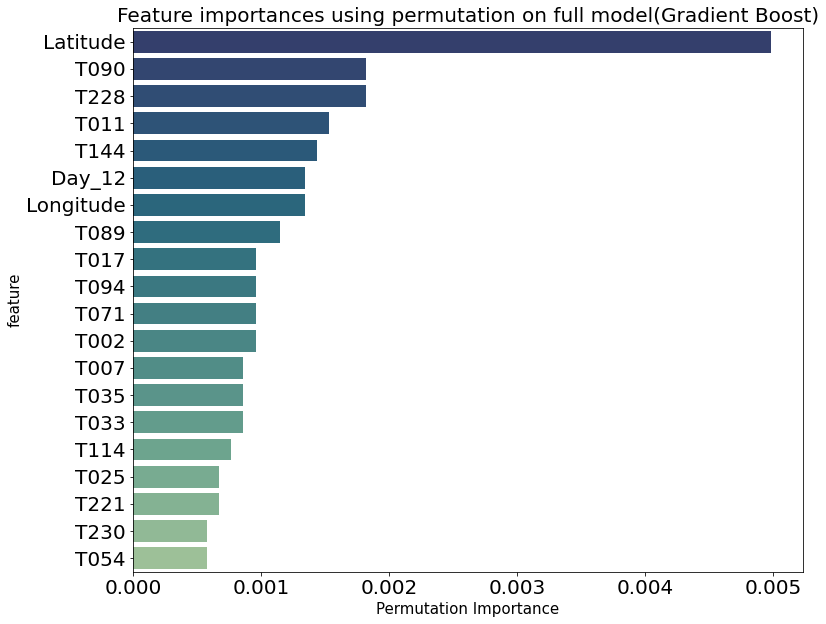

In [48]:
start_time = time.time()
perm_imp = permutation_importance(GBM, Z_test , y_test, n_repeats=5, random_state=42, n_jobs=-1,scoring='accuracy')
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


# Get the top 20 features with high predictive power
gb_importances = pd.DataFrame(data = {'feature':feature,'fea_imp':perm_imp.importances_mean})
gb_importances = gb_importances.sort_values(by=['fea_imp'],ascending=False)[0:20]
fig,ax = plt.subplots(figsize=(12,10))
sns.barplot(gb_importances.fea_imp, gb_importances.feature,orient='h',palette='crest_r')
plt.title("Feature importances using permutation on full model(Gradient Boost)",fontsize=20)
ax.set_xlabel("Permutation Importance",fontsize=15)
ax.set_ylabel("feature",fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

Elapsed time to compute the importances: 62.184 seconds


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


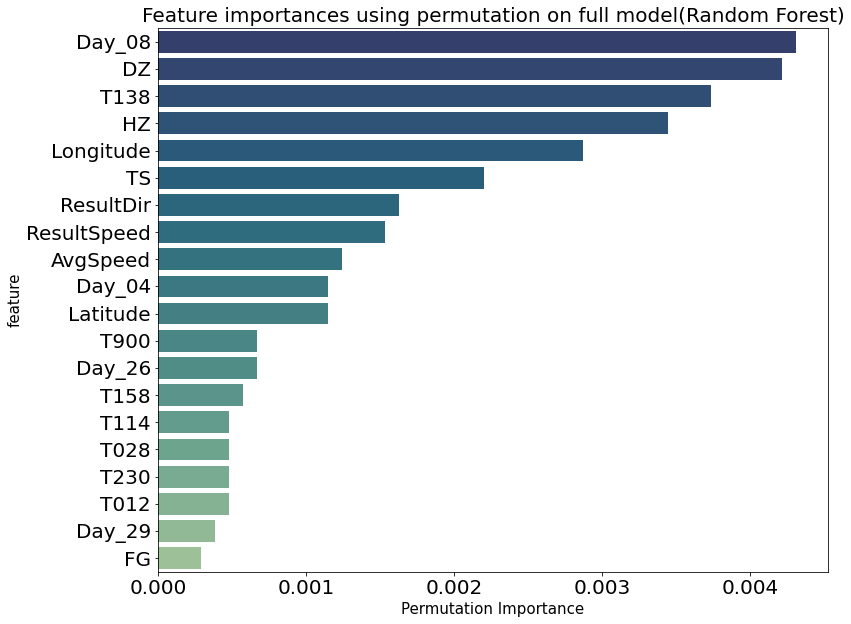

In [51]:
start_time = time.time()
perm_imp = permutation_importance(grid_rf , Z_test , y_test, n_repeats=5, random_state=42, n_jobs=-1,scoring='accuracy')
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


# Get the top 20 features with high predictive power
gb_importances = pd.DataFrame(data = {'feature':feature,'fea_imp':perm_imp.importances_mean})
gb_importances = gb_importances.sort_values(by=['fea_imp'],ascending=False)[0:20]
fig,ax = plt.subplots(figsize=(12,10))
sns.barplot(gb_importances.fea_imp, gb_importances.feature,orient='h',palette='crest_r')
plt.title("Feature importances using permutation on full model(Random Forest)",fontsize=20)
ax.set_xlabel("Permutation Importance",fontsize=15)
ax.set_ylabel("feature",fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [ ]:
# Get Predictions
#predictions = grid_rf.predict(Z_test)

In [ ]:
# Import Test Data
#test = pd.read_csv('data/test_final.csv')

In [ ]:
#submission = pd.DataFrame(test['Id'])
#submission['WnvPresent'] = predictions

In [176]:
#submission['WnvPresent'].value_counts()

0    112242
1      4051
Name: WnvPresent, dtype: int64

In [177]:
# Save csv
#submission.to_csv('data/submission_predictions.csv', index=False)